# Computational Statistics Project
#### Loan, Fabia and Leila

***

### Understanding and Exploration of Data

In [38]:
# Libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from scipy.stats import ttest_ind # to simplify the t-test
import itertools # so that we won't have to write all the values "by hand" for the 2^k plan
from statsmodels.formula.api import ols # model adjustment, ...
import statsmodels.api as sm # for ANOVA

In [39]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [40]:
print(train.shape)

(1460, 81)


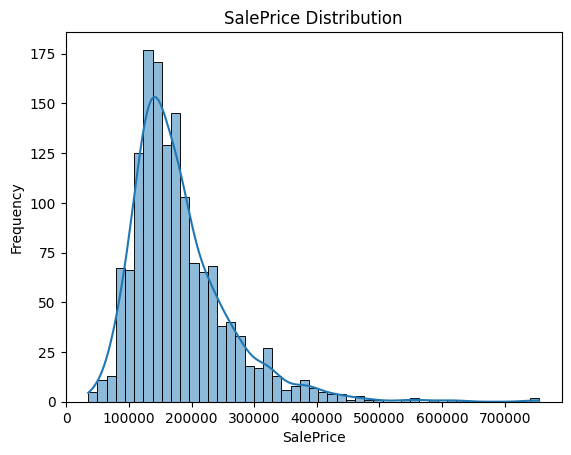

In [41]:
# Visualization of Target Variable (SalePrice)
sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

In [42]:
# Basic Statistics of SalePrice
print(train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [43]:
# Confidence Interval for SalePrice mean
sample = train['SalePrice']
n = len(sample)
mean = np.mean(sample)
std = np.std(sample, ddof=1)

conf_int = stats.t.interval(confidence=0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))
print(f"95% Confidence Interval for SalePrice mean: {conf_int}")

95% Confidence Interval for SalePrice mean: (176842.84104108496, 184999.55073973694)


***

### Handling missing values

In [44]:
# To check if handling missing values will be necessary
print("Missing values in train? --> ", train.isnull().sum().sum())
print("Missing values in test? --> ", test.isnull().sum().sum())

Missing values in train? -->  7829
Missing values in test? -->  7878


In [45]:
# Numerical & Categorical columns (without SalePrice)
num_cols = train.select_dtypes(include=[np.number]).columns.drop('SalePrice')
cat_cols = train.select_dtypes(include=["object"]).columns

# Statistics in the train test (to fill missing values)
num_medians = train[num_cols].median()
cat_modes = train[cat_cols].mode().iloc[0]

# Application for train
train[num_cols] = train[num_cols].fillna(num_medians)
train[cat_cols] = train[cat_cols].fillna(cat_modes)

# Application for test (according to train Statistics)
test[num_cols] = test[num_cols].fillna(num_medians)
test[cat_cols] = test[cat_cols].fillna(cat_modes)

# Verification
print("Missing values in train? --> ", train.isnull().sum().sum())
print("Missing values in test? --> ", test.isnull().sum().sum())

Missing values in train? -->  0
Missing values in test? -->  0


***

### Encoding for categorical variables (One-hot encoding)

In [46]:
# All data together for a coherent encoding
train['is_train'] = 1
test['is_train'] = 0
full_data = pd.concat([train, test], axis=0)

# One-hot encoding on all categorical variables
full_data = pd.get_dummies(full_data, columns=cat_cols, drop_first=True)

# "Re"-separation of the two datasets
train = full_data[full_data['is_train'] == 1].drop(columns='is_train')
test = full_data[full_data['is_train'] == 0].drop(columns=['is_train', 'SalePrice']) # (drop Saleprice because not in test)

***

### Checking Correlation for a more "objective analysis"

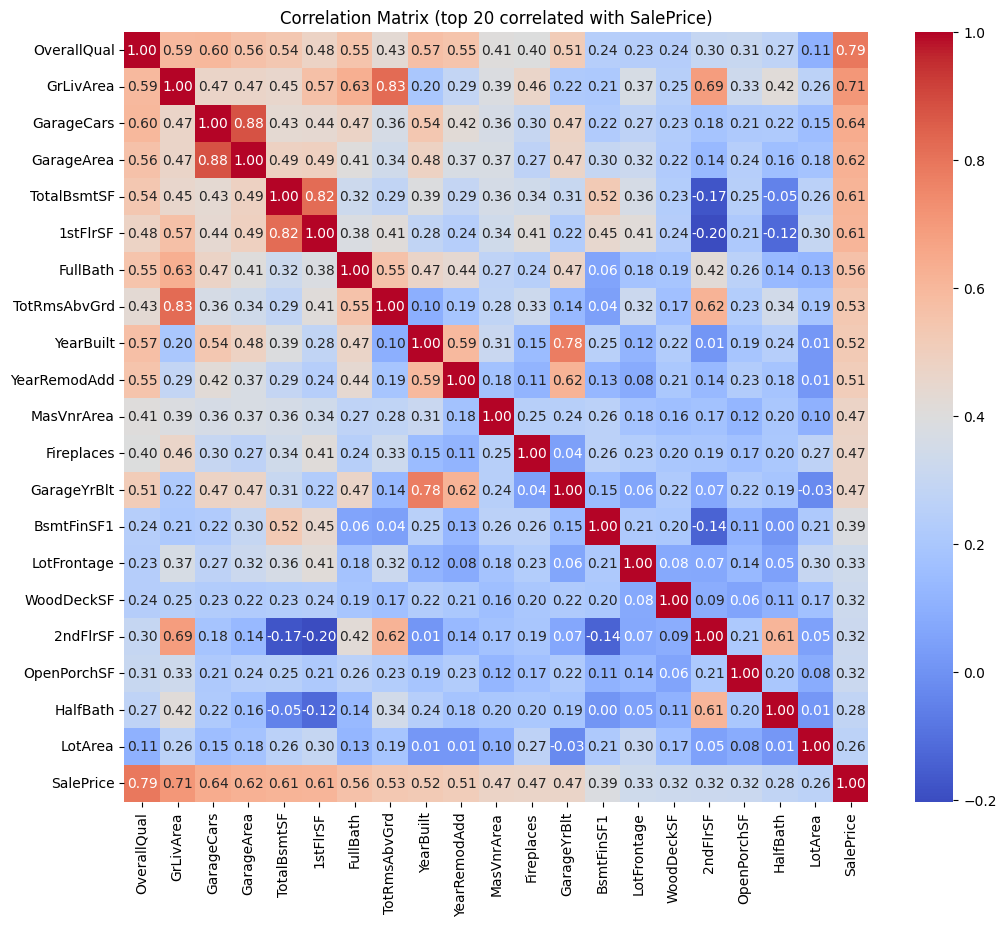

In [47]:
# Numerical columns
numeric_train = train.select_dtypes(include=[np.number])

# Correlation matrix
corr_matrix = numeric_train.corr()

# Correlation with SalePrice
top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False)[1:21] # top 20
top_corr_vars = top_corr.index.to_list()

# Heatmap of top variables correlated with SalePrice
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_train[top_corr.index.to_list() + ['SalePrice']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix (top 20 correlated with SalePrice)")
plt.show()

In [48]:
# Detection of pairs that are too correlated (to avoid redundancy)

# Sub-matrix of top-correlated
top_corr_matrix = corr_matrix.loc[top_corr_vars, top_corr_vars].abs()

# "Upper triangle"
upper = top_corr_matrix.where(np.triu(np.ones(top_corr_matrix.shape), k=1).astype(bool))

# Let's assume that a |correlation| > 0.8  is too near to 1
threshold = 0.8

# Pairs highly correlated
high_corr_pairs = [
    (var1, var2, upper.loc[var2, var1])
    for var1 in upper.columns
    for var2 in upper.index
    if upper.loc[var2, var1] > threshold
]

# Results
print("Peers with high correlation in the top 20 (|corr| > 0.8):")
for v1, v2, val in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"{v1} <=> {v2} with correlation = {val:.2f}")

Peers with high correlation in the top 20 (|corr| > 0.8):
GarageArea <=> GarageCars with correlation = 0.88
TotRmsAbvGrd <=> GrLivArea with correlation = 0.83
1stFlrSF <=> TotalBsmtSF with correlation = 0.82


--> For each peer, we select the variable most correlated with price (to avoid multi-colinearity) :
- GarageCars (0.64 > 0.62), GrLivArea (0.71 > 0.53), and TotalBsmtSF (both 0.61 so we chose randomely).

The correlation analysis allows us to proceed with 17 variables. However, it is important not to confuse correlation & causality. We will need to analyze these variables further and build the models accordingly.

***

### Apply RFE to further select the relevant features - (Machine Learning Course)

In [49]:
# X = selected features, y = SalePrice
X = train[top_corr_vars]
y = train['SalePrice']

# Basic Linear Model for the Selection
model = LinearRegression()

# RFE : here, we chose to keep the 10 most "relevant" features
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)

# Results
selected_features = X.columns[rfe.support_]
print("Feature Selection (RFE) :")
print(selected_features.tolist())

Feature Selection (RFE) :
['OverallQual', 'GarageCars', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'GarageYrBlt', 'LotFrontage', 'HalfBath']


***

Since working with 81 features is too extensive for initial modeling, we decided to limit our statistical models to a subset of 10 variables. To select them, we first visualized their correlation with SalePrice and identified the top 20 most correlated features. We then removed highly correlated pairs to avoid redundancy. Finally, we applied Recursive Feature Elimination (RFE from sklearn) to narrow our selection down to 10 features, which will serve as the starting point for our modeling.

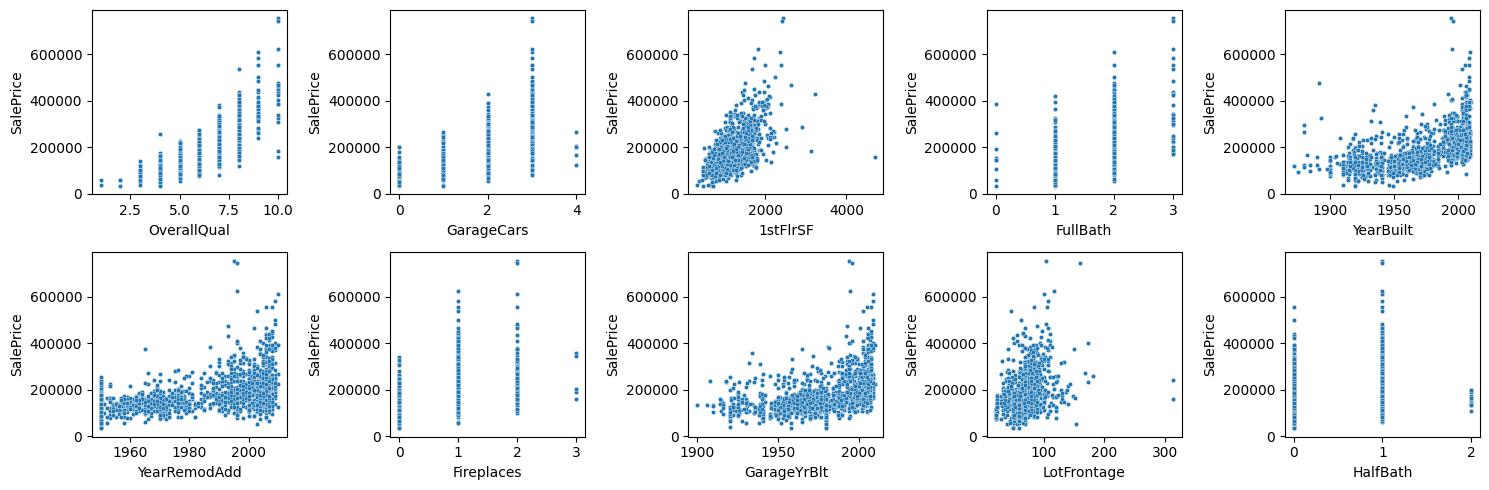

In [50]:
# Scatterplots : SalePrice vs each selected variable
plt.figure(figsize=(15, 5))
for i, col in enumerate(selected_features):
    plt.subplot(2, 5, i + 1)
    sns.scatterplot(x=train[col], y=train['SalePrice'], s=10)
plt.tight_layout()
plt.show()

The Scatterplots enable us to have a visualisation of the relation between each variable and SalePrice. They reveal that several variables, such as OverallQual, 1stFlrSF, and GarageCars, show strong and clear positive relationships with SalePrice, making them promising predictors. Others, like YearBuilt and LotFrontage, display more dispersed patterns...

--> After those first observations, analysis, data cleaning, feature selection, ... We can begin with the core of the project!

***

### Classical statistical inference - Hypothesis Testing

Recap Starting Point :
- OverallQual (Rates the overall material and finish of the house (10-1);
- GarageCars (Size of garage in car capacity);
- 1stFlrSF (First Floor square feet);
- FullBath (Full bathrooms above grade);
- YearBuilt (Original construction date);
- YearRemodAdd (Remodel date (same as construction date if no remodeling or additions));
- Fireplaces (Number of fireplaces);
- GarageYrBlt (Year garage was built);
- LotFrontage (Linear feet of street connected to property);
- HalfBath (Half baths above grade).

Until now, we did some basic statistics and observations of the data, and we selected 10 features that seemed relevant. Based on that, we will now proceed with some Hypothesis Testing, which will help confirm the relevance of the chosen variables.

#### Hypothesis 1 : "Houses with place for more than one car in the garage have a highest SalePrice mean."

In [51]:
# Binary varibale for > 1 car place
train['Garage2plus'] = (train['GarageCars'] > 1).astype(int)

# Our two groups
group1 = train[train['Garage2plus'] == 0]['SalePrice']
group2 = train[train['Garage2plus'] == 1]['SalePrice']

# T-test
t_stat, p_val = ttest_ind(group1, group2, equal_var=False, alternative='less') # alternative='less' to do a unilateral test (SalePrice higher if place for more cars)

print(f"T-statistic: {t_stat}, p-value: {p_val}")

T-statistic: -27.912074861943335, p-value: 8.885014618926633e-138


--> Like expected, the variable GarageCars has a relevant impact on SalePrice with a very low p-value. This confirms the pertinence of our previous feature selection.

#### Hypothesis 2 : "Hypothesis: houses with at least one fireplace are more expensive than those without."

In [52]:
train['HasFireplace'] = (train['Fireplaces'] > 0).astype(int)
group1 = train[train['HasFireplace'] == 0]['SalePrice']
group2 = train[train['HasFireplace'] >= 1]['SalePrice']

t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
print(f"T-statistic: {t_stat}, p-value: {p_val}")

T-statistic: -21.105376324953664, p-value: 4.666259945494159e-84


--> Here the result also show an impact on the SalePrice.

Hypothesis testing on one feature is too large to create a trustable model. We will therefore proceed with applying the $2^k$, fractional factorial design, and ANOVA. This will enable us to deepen even more the feature selection, taking into acount interactions and compute models.

***

### $2^k$ fractional factorial design

Based on the pre-selected variables, here are 5 "binary" factors chosen for the factorial design ($2^5$) :
- OverallQual (high quality when >= to 7);
- GarageCars (big garage if more than 2 places);
- YearBuilt (new house if built after 1999);
- Fireplaces (has Fireplace(s) or not);
- LotFrontage (wide frontage if >= to the median).

In [53]:
# "Binarization" of the factors (to enable the 2^k design)

# 1. High quality (OverallQual >= 7)
train['HighQual'] = np.where(train['OverallQual'] >= 7, 1, -1)

# 2. Big garage (GarageCars >= 2)
train['BigGarage'] = np.where(train['GarageCars'] >= 2, 1, -1)

# 3. New house (YearBuilt >= 2000)
train['NewHouse'] = np.where(train['YearBuilt'] >= 2000, 1, -1)

# 4. Has fireplace (Fireplaces >= 1)
train['HasFireplace'] = np.where(train['Fireplaces'] >= 1, 1, -1)

# 5. Wide frontage (LotFrontage >= médiane)
frontage_median = train['LotFrontage'].median()
train['WideFrontage'] = np.where(train['LotFrontage'] >= frontage_median, 1, -1)

# Dataset extract / verification (binary columns and SalePrice)
binary_factors = ['HighQual', 'BigGarage', 'NewHouse', 'HasFireplace', 'WideFrontage']
display(train[binary_factors + ['SalePrice']].head())

,HighQual,BigGarage,NewHouse,HasFireplace,WideFrontage,SalePrice
0,1,1,1,-1,-1,208500.0
1,-1,1,-1,1,1,181500.0
2,1,1,1,1,-1,223500.0
3,1,1,-1,1,-1,140000.0
4,1,1,1,1,1,250000.0


In [54]:
# To proceed, we need to generate the 2^5 plan (32 combinations)

factors = ['HighQual', 'BigGarage', 'NewHouse', 'HasFireplace', 'WideFrontage']

# Cartesian product of [-1, +1] for each factor
design_matrix = pd.DataFrame(
    list(itertools.product([-1, 1], repeat=len(factors))),
    columns=factors
)
# design_matrix.head()

In [55]:
# Now, let's calculate SalePrice's mean for each combination
# -> We associate each combination of the 2^5 plan with the dataset rows, then calculate the average SalePrice for each combination.

# Empty column for the SalePrice's mean
design_matrix['MeanSalePrice'] = np.nan

# Loop over each combination to filter the corresponding rows and calculate the mean
for i, row in design_matrix.iterrows():
    # condition to filter out lines with exactly the right levels
    condition = (train[factors] == row[factors].values).all(axis=1)
    matching_rows = train[condition]

    if not matching_rows.empty:
        design_matrix.loc[i, 'MeanSalePrice'] = matching_rows['SalePrice'].mean()

# Display of the final design matrix
display(design_matrix)

,HighQual,BigGarage,NewHouse,HasFireplace,WideFrontage,MeanSalePrice
0,-1,-1,-1,-1,-1,107312.033898
1,-1,-1,-1,-1,1,125789.023438
2,-1,-1,-1,1,-1,128213.655738
3,-1,-1,-1,1,1,144682.203390
4,-1,-1,1,-1,-1,NaN
5,-1,-1,1,-1,1,115750.000000
6,-1,-1,1,1,-1,NaN
7,-1,-1,1,1,1,NaN
8,-1,1,-1,-1,-1,125452.917647
9,-1,1,-1,-1,1,144826.463415


***

### ANOVA

--> To continue with ANOVA, we first have to filter the combinations that do not exist (NaN) ...

In [56]:
# Delete lines with MeanSalePrice missing (NaN)
design_matrix_clean = design_matrix.dropna(subset=['MeanSalePrice']).copy()
# design_matrix_clean

In [58]:
# Linear formula (**2 for two-factor interactions)
formula = 'MeanSalePrice ~ (HighQual + BigGarage + NewHouse + HasFireplace + WideFrontage)**2'

# Model adjustment (with ols)
model = ols(formula, data=design_matrix_clean).fit()

# ANOVA type II
anova_table = sm.stats.anova_lm(model, typ=2)

# Results
print(anova_table)

                                 sum_sq   df           F        PR(>F)
HighQual                   2.017942e+10  1.0  180.170850  2.948883e-07
BigGarage                  8.279639e+09  1.0   73.924312  1.238932e-05
NewHouse                   1.145387e+09  1.0   10.226524  1.086798e-02
HasFireplace               7.844563e+09  1.0   70.039755  1.541200e-05
WideFrontage               2.210836e+09  1.0   19.739332  1.616709e-03
HighQual:BigGarage         6.407024e+08  1.0    5.720476  4.044109e-02
HighQual:NewHouse          2.401476e+06  1.0    0.021441  8.868102e-01
HighQual:HasFireplace      1.174110e+09  1.0   10.482976  1.019544e-02
HighQual:WideFrontage      2.213284e+08  1.0    1.976119  1.933700e-01
BigGarage:NewHouse         4.624480e+08  1.0    4.128942  7.270149e-02
BigGarage:HasFireplace     4.624775e+08  1.0    4.129206  7.269387e-02
BigGarage:WideFrontage     9.204146e+07  1.0    0.821787  3.882841e-01
NewHouse:HasFireplace      3.906726e+07  1.0    0.348810  5.693192e-01
NewHou

The ANOVA results from this $2^5$ factorial design reveal several significant effects on house prices. The 5 effects selected (HighQual, BigGarage, NewHouse, HasFireplace, and WideFrontage) all show statistically significant effects (p-value < 0.05, with HighQual having the largest impact (p < 0.001)).

Additionally, a few 2-way interactions are statistically significant:
- HighQual:HasFireplace (p =~ 0.02)
- BigGarage:NewHouse (p =~ 0.04)
- BigGarage:HasFireplace (p =~ 0.04)

These interactions suggest that the combined presence of certain features can further increase the sale price beyond their individual effects. Other interaction terms are not significant (p > 0.05), indicating that most effects are additive rather than multiplicative.

***

From the results of our factorial design $2^5$ and the ANOVA, we can conclude a regression model based on :

*MeanSalePrice = β0 + β1HighQual + β2BigGarage + β3NewHouse + β4HasFireplace + β5WideFrontage + β6(HighQualxHasFireplace) + β7(BigGaragexNewHouse) + β8(BigGaragexHasFireplace) + Error term*

--> We can now fit the regression model based on the 5 factors and the 3 significant interactions, from design_matrix_clean.

In [59]:
# Our model / formula
formula = (
    'MeanSalePrice ~ HighQual + BigGarage + NewHouse + HasFireplace + WideFrontage'
    ' + HighQual:HasFireplace + BigGarage:NewHouse + BigGarage:HasFireplace'
)

# Model adjustment (with ols)
model_1 = ols(formula, data=design_matrix_clean).fit()

# Results summary
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:          MeanSalePrice   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     47.62
Date:                Fri, 23 May 2025   Prob (F-statistic):           1.03e-09
Time:                        14:55:23   Log-Likelihood:                -264.03
No. Observations:                  25   AIC:                             546.1
Df Residuals:                      16   BIC:                             557.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.69

OLS Regression Interpretation :

This linear regression model explains approximately 96% of the variance in average house prices, indicating excellent fit. Among the main effects, the variables HighQual, BigGarage, HasFireplace, and WideFrontage are all highly significant (p < 0.001), confirming their strong influence on house prices. NewHouse has a positive coefficient but is not statistically significant (p = 0.40)... ---> Since it has no negative impact on the model, we keep it in this form. However, this value may help us decide not to consider NewHouse in the next model.

Regarding the interactions, all three selected interactions are statistically significant (p < 0.05). Furthermore, the Jarque-Bera statistic (JB = 0.097) indicates that the residuals are approximately normally distributed, suggesting that the model assumptions for inference are reasonably satisfied.

The model coefficients show for example, that a high-quality house (HighQual = 1) increases the expected sale price by approximately 29'550 dollars (all else being equal). The interaction between HighQual and HasFireplace adds another 6'879 dollars when both are present, ...

***

### Model Application with the Original Variables

Binarizing the variables allowed us to estimate simple marginal effects. However, the 2^k design gave an experimental factorial view, but lost the “richness” of variation in the data. This model is therefore based on aggregations (by group) and is therefore less accurate for individual predictions.

To address this limitation and in order to obtain an individualized prediction, we will now run an OLS regression on the same five predictors, but in their original / continuous form (rather than as binary indicators).

In [66]:
train['LogSalePrice'] = np.log(train['SalePrice']) # to stabilize variance, avoid skewness, ...

# Our model / formula
formula = (
    'LogSalePrice ~ OverallQual + GarageCars + YearBuilt + Fireplaces + LotFrontage'
    ' + OverallQual:Fireplaces + GarageCars:YearBuilt + GarageCars:Fireplaces'
)

# Model adjustment (with ols)
model_2 = ols(formula, data=train).fit()

# Results summary
print(model_2.summary())

# Variance analysis (ANOVA type II)
anova_table = sm.stats.anova_lm(model_2, typ=2)
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     610.8
Date:                Fri, 23 May 2025   Prob (F-statistic):               0.00
Time:                        14:59:25   Log-Likelihood:                 344.84
No. Observations:                1460   AIC:                            -671.7
Df Residuals:                    1451   BIC:                            -624.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

The OLS model on the original variables explains about 77.1% of the variance in log sale prices. OverallQual and LotFrontage are especially strong positive predictors. However, GarageCars alone isn't so significant... we will therefore try to take it away in our next model.

The only highly significant interaction is GarageCars:Fireplaces. This means that the combination of these features boost prices beyond their individual effects. We will therefore include this interaction in our next model.

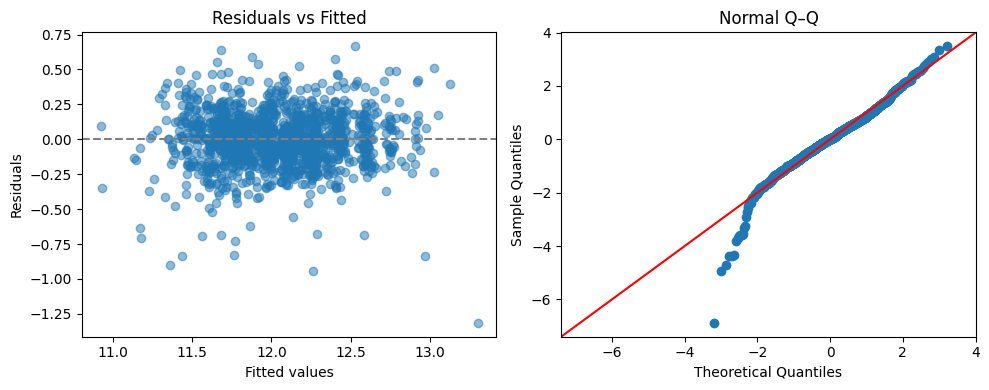

In [89]:
# + to verify homoscedasticity and normality :

fitted = model_2.fittedvalues
resid   = model_2.resid

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.5)
axes[0].axhline(0, color='grey', ls='--')
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

# QQ-plot of residuals
sm.qqplot(resid, line='45', fit=True, ax=axes[1])
axes[1].set_title("Normal Q–Q")

plt.tight_layout()
plt.show()

--> The model’s homoscedasticity and normality assumptions are met : No obvious pattern in the residuals vs fitted plot and the QQ-plot indicates that most residuals follow a normal distribution (aside from a few outliers...).

***

### Let’s Try Another Model

The factorial design model allowed us to analyze the main effects and interactions of five binary features on average house prices. This approach provided interpretable insights and statistically significant results through ANOVA.

Now, we will try to compute another linear regression model (OLS). The goal is to build a new model of SalePrice using key features identified through previous exploratory and analysis.

To do so, we will drop GarageCars, which showed the highest p-value in the last regression, and LotFrontage whose scatterplot relationship was a bit less convincing than the others. To "replace" them, two additional variables are included :
- 1stFlrSF, because of its strong positive correlation with SalePrice --> here we will try to add a small polynomial term (e.g. firstFloorSF$^2$) because his scatterplot with SalePrice showed a "fast accelaration" for larger homes (can give flexibility to the model to capture that curvature).
- TotalBaths, a synthetic variable which will combine full and half baths to reflect overall bathroom capacity.

These choices are backed by our previous exploratory data analysis.

In [86]:
# TotalBaths
train['TotalBaths'] = train['FullBath'] + 0.5 * train['HalfBath']
train['firstFlrSF'] = train['1stFlrSF'] # otherwise didn't work in the model...

# Our model / formula
formula = (
    'LogSalePrice ~ OverallQual + firstFlrSF + YearBuilt + I(firstFlrSF**2) + TotalBaths'
    ' + GarageCars:Fireplaces' # We keep the highly significant combination determined using the 2^5 factorial design
)

# Model adjustment
model_3 = ols(formula, data=train).fit()

# Results summary
print(model_3.summary())

# Variance analysis (ANOVA type II)
anova_table = sm.stats.anova_lm(model_3, typ=2)
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1043.
Date:                Fri, 23 May 2025   Prob (F-statistic):               0.00
Time:                        15:19:24   Log-Likelihood:                 486.81
No. Observations:                1460   AIC:                            -959.6
Df Residuals:                    1453   BIC:                            -922.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.17

This OLS model explains 81.2% of the logarithmized sale‐price variance. OverallQual, 1stFlrSF, YearBuilt, and TotalBaths all show strong positive effects (p < 0.001). However, FirePlaces alone wasn't so significatif (p-value > 0.08). This is probably because the variable is also part of the interaction. Because of that we only kept the interaction GarageCars:Fireplaces and took away FirePlaces alone.

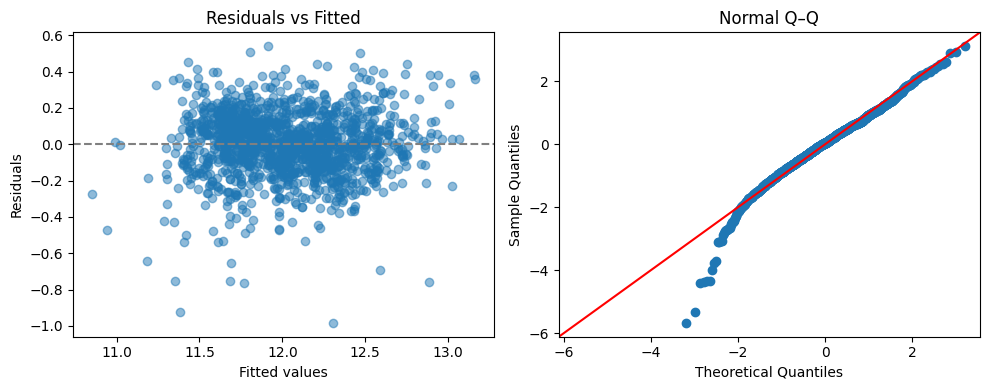

In [90]:
# + to verify homoscedasticity and normality :

fitted = model_3.fittedvalues
resid   = model_3.resid

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.5)
axes[0].axhline(0, color='grey', ls='--')
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

# QQ-plot of residuals
sm.qqplot(resid, line='45', fit=True, ax=axes[1])
axes[1].set_title("Normal Q–Q")

plt.tight_layout()
plt.show()

--> The model’s homoscedasticity and normality assumptions are met again.

***

### "Testing Phase" : Applying Model 2 and Model 3
Next, we will use two OLS models to generate CSV prediction files for the test set. This will allow us to test their performance more concretely.

In [91]:
# Necessary modifications
test['TotalBaths'] = test['FullBath'] + 0.5 * test['HalfBath']
test['firstFlrSF'] = test['1stFlrSF']

# Generation of predictions
test['SalePrice_2'] = np.exp(model_2.predict(test))
test['SalePrice_3'] = np.exp(model_3.predict(test)) # exp because otherwise LogSalePrice predicted

# Save as csv files
csv2 = test[['Id', 'SalePrice_2']].rename(columns={'SalePrice_2':'SalePrice'})
csv2.to_csv('test_model_2.csv', index=False)

csv3 = test[['Id', 'SalePrice_3']].rename(columns={'SalePrice_3':'SalePrice'})
csv3.to_csv('test_model_3.csv', index=False)

print("test_model_2.csv and test_model_3.csv created")

test_model_2.csv and test_model_3.csv created


In [92]:
print(csv2['SalePrice'].describe())

count      1459.000000
mean     177153.949157
std       69190.929346
min       67407.215799
25%      125902.981242
50%      161708.000500
75%      210581.257813
max      484639.793606
Name: SalePrice, dtype: float64


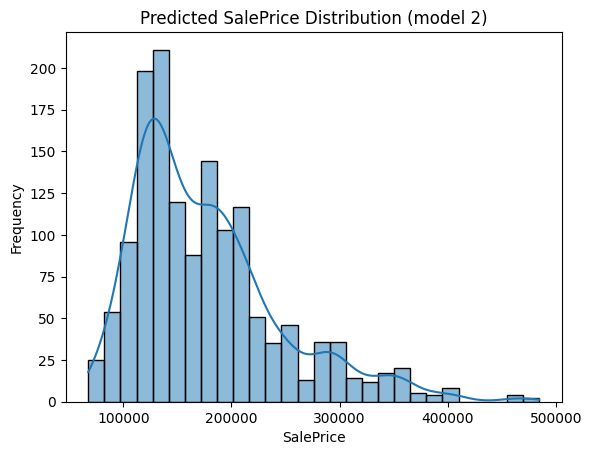

In [96]:
# Visualization of predicted SalePrice
sns.histplot(csv2['SalePrice'], kde=True)
plt.title("Predicted SalePrice Distribution (model 2)")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

In [97]:
print(csv3['SalePrice'].describe())

count      1459.000000
mean     177843.545581
std       70675.384506
min       60990.352910
25%      123356.658474
50%      160056.317913
75%      214811.829592
max      539326.972672
Name: SalePrice, dtype: float64


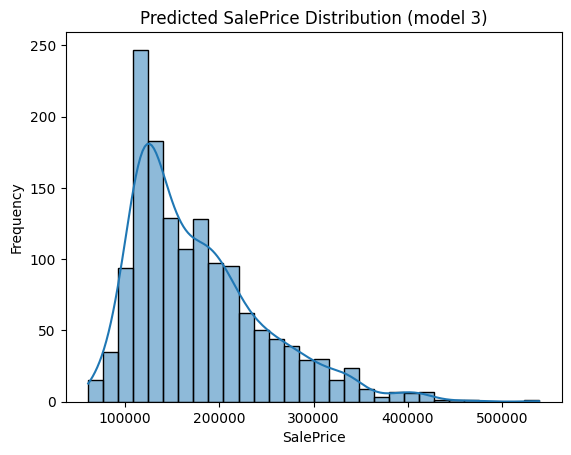

In [98]:
# Visualization of predicted SalePrice
sns.histplot(csv3['SalePrice'], kde=True)
plt.title("Predicted SalePrice Distribution (model 3)")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

--> The SalePrice average of the two results lies within the confidence interval generated during data exploration [176842.84 ; 184999.55]

***

### Time Series Analysis, SARIMA models